In [1]:
import os
import operator
import random
import numpy as np
import pandas as pd
import csv
import re

from itertools import chain, islice, product
from functools import partial

import nltk
from nltk.tokenize import word_tokenize

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Layer, Lambda, Input, InputLayer, Embedding, Dense, TimeDistributed, Flatten, Reshape, Activation, Dropout, BatchNormalization, CuDNNLSTM, LSTM, Bidirectional, Multiply
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from pprint import pprint

import gc

Using TensorFlow backend.
W0512 23:01:52.852059 26228 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)
    
set_seed(1992)

<h2>Preprocessing</h2>

We operate on a subset of two datasets:
<ol>
    <li>
        <h4>LingSpam Dataset (Bare)</h4>
        <p>
            This is the dataset that we used in the 2nd assignment.
            It consists of a few large emails, appriximately 1000 messages with an average of 3500 words.
    </li>
    <li>
        <h4>Kaggles Spam/Ham Dataset</h4>
        <p>
            This dataset is bigger, consisting of approximately 5500 messages.
            Each message however is quiet short and a lot of jargon is used in them.
        </p>
    </li>
</ol>

In [3]:
lingspam_data_path = "lingspam_public/bare"
kaggle_data_path   = "Kaggle/kaggle_spam_data.csv"

In [4]:
def load_lingspam_data(path):

    ham, spam = [], []

    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            with open(os.path.join(dirpath, filename), encoding="utf8") as file:
                message = file.read()
            if filename.startswith("spm"):
                spam.append(message)
            else:
                ham.append(message)

    return ham, spam

In [5]:
def load_kaggle_data(path):
    
    ham, spam = [], []
    
    pattern = re.compile("\"?(?P<Category>spam|ham),(?:\"\")?(?P<Text>.*?)(?:\"\"\")?;+")
    
    with open(path, 'r', encoding="utf8") as file:
        for line in file.readlines():
            match = pattern.match(line)
            if match:
                text = " ".join(word_tokenize(match["Text"]))
                if match["Category"].startswith("s"):
                    spam.append(text)
                else:
                    ham.append(text)
            
    return ham, spam

In [6]:
dataset = "*" # Specify the dataset to be loaded: kaggle, lingspam, or both

ham, spam = \
    load_kaggle_data(kaggle_data_path) if dataset.startswith("k") else (
        load_lingspam_data(lingspam_data_path) if dataset.startswith("l") else
        tuple(map(operator.concat, load_kaggle_data(kaggle_data_path), load_lingspam_data(lingspam_data_path)))
    )
 
print("Ham: {}, Spam: {}".format(len(ham), len(spam)))

Ham: 7226, Spam: 1227


In [7]:
def data_split(x, y, sizes=(0.1, 0.1)):
    
    data_size = len(x)
    splits = []
    
    for size in sizes:
        x, test_x, y, test_y = train_test_split(x, y, test_size=int(data_size*size), shuffle=True)
        splits.append((test_x, test_y))
    splits.append((x, y))
    
    return splits

In [8]:
x = ham + spam
y = [0] * len(ham) + [1] * len(spam)

(test_x, test_y), (valid_x, valid_y), (train_x, train_y) = data_split(x, y, sizes=(0.2, 0.08))

print("Split Sizes: {}".format(list(map(len, (train_x, valid_x, test_x)))))

Split Sizes: [6087, 676, 1690]


<h3>Tokenizer Initialization</h3>
<p>We consider two tokenizers. <i>Tokenizer_TRAIN_GLB</i> is fitted in all tokens onservable in the training set. <i>Tokenizer_UNK</i> is fitted in a subset of the training sequences in order to simulate the unobservability of a number of tokens in the validation data.</p>

In [9]:
tokenizer_GLB = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_GLB.fit_on_texts(train_x)

print("Tokens discovered by Tokenizer_GLB: {}".format(len(tokenizer_GLB.word_index)))

Tokens discovered by Tokenizer_GLB: 54841


In [10]:
tokenizer_UNK = Tokenizer(num_words=None, lower=True, oov_token="*UNK*")
tokenizer_UNK.fit_on_texts(random.sample(train_x, len(train_x) - len(valid_x))) # We want the number of unknown words in the train set to be approximately the same as in the validation set.

print("Tokens discovered by Tokenizer_UNK: {}".format(len(tokenizer_UNK.word_index)))

Tokens discovered by Tokenizer_UNK: 51416


<h3>Tokenization</h3>
<p>We transform each set in sequences of tokens according the chosen tokenizer.</p>

In [11]:
tokenizer = tokenizer_UNK

In [12]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=150, padding="post", truncating="post") # We are constrained by the hardware limitations.
input_length = len(train_sequences[0])

In [13]:
valid_sequences = pad_sequences(tokenizer.texts_to_sequences(valid_x), maxlen=input_length, padding="post", truncating="post")
test_sequences  = pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=input_length, padding="post", truncating="post")

<h2>Utilities</h2>

In [14]:
def create_rnn_model(rnn_stack_size=1, use_atention=False, mlp_model=None):
    assert rnn_stack_size > 0
    
    l_Input = Input((input_length,), name="In")

    l_Embeddings = Embedding(
        name="Embeddings",
        input_dim=embedding_weights.shape[0],
        output_dim=embedding_weights.shape[1],
        input_length=input_length,
        embeddings_initializer="zeros",
        weights=[embedding_weights],
        trainable=False
    )(l_Input)

    m_BiLSTM = Sequential(name="BiLSTM_Stack")
    for _ in range(rnn_stack_size - 1):
        m_BiLSTM.add(Bidirectional(CuDNNLSTM(100, return_sequences=True)))
        
    if use_atention:
        m_BiLSTM.add(Bidirectional(CuDNNLSTM(100, return_sequences=True)))
    else:
        m_BiLSTM.add(Bidirectional(CuDNNLSTM(100)))
        
        
    l_BiLSTM = m_BiLSTM(l_Embeddings)

    m_Out = Sequential(name="Out")
    
    if use_atention:

        m_Attention = Sequential(name="Attention")
        m_Attention.add(mlp_model)
        m_Attention.add(Flatten())
        m_Attention.add(Activation("softmax"))
        m_Attention.add(Reshape((input_length, 1)))
        l_Attention = m_Attention(l_BiLSTM)

        l_Multiply = Multiply(name="Multiply")([l_BiLSTM, l_Attention])

        m_Out.add(Lambda(lambda x: K.sum(x, axis=1)))
        m_Out.add(Dense(1, activation="sigmoid"))
        l_Out = m_Out(l_Multiply)
    
    else:
        
        m_Out.add(Dense(1, activation="sigmoid"))
        l_Out = m_Out(l_BiLSTM)

    model = Model(inputs=l_Input, outputs=l_Out)
    
    return model

In [15]:
def clean_model(model):
    
    K.clear_session()
    del model
    gc.collect() 

In [16]:
def tune_model(build_fn, param_grid={}, epochs=100, patience=6, verbose=False):

    tune_history = []
    best_score = np.inf
    best_index = None
    
    param_iter = product(*param_grid.values())
    for params in param_iter:

        model = build_fn(**dict(zip(param_grid.keys(), params)))
        model.summary()

        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

        history = model.fit(
            train_sequences, train_y,
            validation_data=(valid_sequences, valid_y),
            batch_size=16,
            epochs=epochs,
            callbacks=[EarlyStopping(patience=patience, restore_best_weights=True, verbose=verbose)],
            verbose=verbose
        )
        
        val_loss = np.min(history.history["val_loss"])
        if val_loss < best_score:
            best_score = val_loss
            best_index = len(tune_history)
            
        tune_history.append({
            "params": params,
            "model": model,
            "fit_history": history
        })
        
    return tune_history, best_index

In [17]:
def evaluate_model(model, sequences, y):
    
    print(classification_report(y, (model.predict(sequences).flatten() >= 0.5).astype(float)))

In [18]:
def plot_history(history):
    
    plt.plot(
        history.history["acc"],
        label="Train"
    )
    plt.plot(
        history.history["val_acc"],
        label="Validation"
    )
    
    plt.title("Model Accuracy")
    plt.ylabel("Accuray")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="best")
    
    plt.show() 

<h2>BiLSTM on Pretrained (Glove) Embeddings</h2>

In [19]:
glove_embeddings_path = "glove.6B/glove.6B.100d.txt"
embeddings_df = pd.read_csv(glove_embeddings_path, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE, na_values=None, keep_default_na=False)

In [20]:
token_iter = map(
    operator.itemgetter(0),
    sorted(
        filter(lambda item: item[1] <= tokenizer.num_words, tokenizer.word_index.items()) if tokenizer.num_words
            else tokenizer.word_index.items(),
        key=operator.itemgetter(1)
    )
)

embedding_weights = embeddings_df.reindex(chain((None,), token_iter), fill_value=0.0).values # The zero-indexed vector is used only for masking by the layer.

print("Non-Zero Embeddings: {}".format(np.count_nonzero(embedding_weights, axis=0)[0]))

Non-Zero Embeddings: 33910


In [21]:
param_grid = {
    "use_atention": [False],
    "rnn_stack_size": [2],
    "mlp_model": [None]
}

history, best_index = tune_model(create_rnn_model, param_grid=param_grid, epochs=30, patience=6, verbose=True)

Instructions for updating:
Colocations handled automatically by placer.


W0512 23:02:20.293281 26228 deprecation.py:323] From C:\Users\josep\Anaconda3\envs\NLP\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
In (InputLayer)              (None, 150)               0         
_________________________________________________________________
Embeddings (Embedding)       (None, 150, 100)          5141700   
_________________________________________________________________
BiLSTM_Stack (Sequential)    (None, 200)               403200    
_________________________________________________________________
Out (Sequential)             (None, 1)                 201       
Total params: 5,545,101
Trainable params: 403,401
Non-trainable params: 5,141,700
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


W0512 23:02:24.134842 26228 deprecation.py:323] From C:\Users\josep\Anaconda3\envs\NLP\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 6087 samples, validate on 676 samples
Epoch 1/30
6087/6087 [==============================] - 15s 2ms/step - loss: 0.1634 - acc: 0.9389 - val_loss: 0.0886 - val_acc: 0.9675
Epoch 2/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0889 - acc: 0.9703 - val_loss: 0.0862 - val_acc: 0.9749
Epoch 3/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0650 - acc: 0.9809 - val_loss: 0.0620 - val_acc: 0.9778
Epoch 4/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0476 - acc: 0.9859 - val_loss: 0.0616 - val_acc: 0.9822
Epoch 5/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0446 - acc: 0.9851 - val_loss: 0.0541 - val_acc: 0.9808
Epoch 6/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0418 - acc: 0.9875 - val_loss: 0.0493 - val_acc: 0.9808
Epoch 7/30
6087/6087 [==============================] - 12s 2ms/step - loss: 0.0287 - acc: 0.9923 - val_loss: 0.0437 - val_acc: 0.9852
Epoch 8/

In [22]:
print("Tune Results: #{}, {}".format(best_index + 1, dict(zip(param_grid.keys(), history[best_index]["params"]))))

Tune Results: #1, {'use_atention': False, 'rnn_stack_size': 2, 'mlp_model': None}


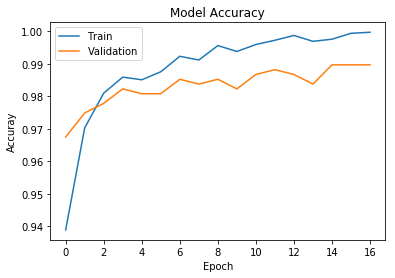

In [23]:
plot_history(history[best_index]["fit_history"])

In [24]:
evaluate_model(history[best_index]["model"], train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5212
           1       1.00      1.00      1.00       875

   micro avg       1.00      1.00      1.00      6087
   macro avg       1.00      1.00      1.00      6087
weighted avg       1.00      1.00      1.00      6087



In [25]:
evaluate_model(history[best_index]["model"], valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       592
           1       0.95      0.94      0.95        84

   micro avg       0.99      0.99      0.99       676
   macro avg       0.97      0.97      0.97       676
weighted avg       0.99      0.99      0.99       676



In [26]:
evaluate_model(history[best_index]["model"], test_sequences, test_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1422
           1       0.97      0.93      0.95       268

   micro avg       0.98      0.98      0.98      1690
   macro avg       0.98      0.96      0.97      1690
weighted avg       0.98      0.98      0.98      1690



In [27]:
for entry in history:
    clean_model(entry["model"])

<h2>BiLSTM on Pretrained (Glove) Embeddings + Attention (MLP)</h2>

In [28]:
param_grid = {
    "use_atention": [True],
    "rnn_stack_size": [2],
    "mlp_model": [
        Sequential([
            TimeDistributed(Dense(1))
        ]),
        Sequential([
            TimeDistributed(Dense(512, activation="relu")),
            Dropout(0.5),
            TimeDistributed(Dense(128, activation="relu")),
            Dropout(0.5),
            TimeDistributed(Dense(1))
        ])
    ]
}

history, best_index = tune_model(create_rnn_model, param_grid=param_grid, epochs=30, patience=6, verbose=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
In (InputLayer)                 (None, 150)          0                                            
__________________________________________________________________________________________________
Embeddings (Embedding)          (None, 150, 100)     5141700     In[0][0]                         
__________________________________________________________________________________________________
BiLSTM_Stack (Sequential)       (None, 150, 200)     403200      Embeddings[0][0]                 
__________________________________________________________________________________________________
Attention (Sequential)          (None, 150, 1)       201         BiLSTM_Stack[1][0]               
__________________________________________________________________________________________________
Multiply (

W0512 23:09:11.215437 26228 deprecation.py:506] From C:\Users\josep\Anaconda3\envs\NLP\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
In (InputLayer)                 (None, 150)          0                                            
__________________________________________________________________________________________________
Embeddings (Embedding)          (None, 150, 100)     5141700     In[0][0]                         
__________________________________________________________________________________________________
BiLSTM_Stack (Sequential)       (None, 150, 200)     403200      Embeddings[0][0]                 
__________________________________________________________________________________________________
Attention (Sequential)          (None, 150, 1)       168705      BiLSTM_Stack[1][0]               
__________________________________________________________________________________________________
Multiply (

In [29]:
print("Tune Results: #{}, {}".format(best_index + 1, dict(zip(param_grid.keys(), history[best_index]["params"]))))

Tune Results: #2, {'use_atention': True, 'rnn_stack_size': 2, 'mlp_model': <keras.engine.sequential.Sequential object at 0x0000025C1965E198>}


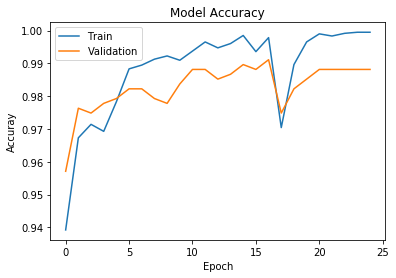

In [30]:
plot_history(history[best_index]["fit_history"])

In [31]:
evaluate_model(history[best_index]["model"], train_sequences, train_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5212
           1       0.99      0.99      0.99       875

   micro avg       1.00      1.00      1.00      6087
   macro avg       1.00      0.99      0.99      6087
weighted avg       1.00      1.00      1.00      6087



In [32]:
evaluate_model(history[best_index]["model"], valid_sequences, valid_y)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       592
           1       0.91      0.95      0.93        84

   micro avg       0.98      0.98      0.98       676
   macro avg       0.95      0.97      0.96       676
weighted avg       0.98      0.98      0.98       676



In [33]:
evaluate_model(history[best_index]["model"], test_sequences, test_y)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1422
           1       0.97      0.97      0.97       268

   micro avg       0.99      0.99      0.99      1690
   macro avg       0.98      0.98      0.98      1690
weighted avg       0.99      0.99      0.99      1690



In [34]:
for entry in history:
    clean_model(entry["model"])

<h2>BiLSTM on Pretrained (Glove + ELMo) Embeddings (Not Working)</h2>

In [ ]:
class ELMo(Layer):
    
    def __init__(self, index_word, output_mode="default", **kwargs):
        
        assert output_mode in ["default", "word_emb", "lstm_outputs1", "lstm_outputs2", "elmo"]
        
        self.index_word = index_word
        self.output_mode = output_mode
        
        super().__init__(**kwargs)
    
    
    def build(self, input_shape):
        
        self.max_length = input_shape[1]
        
        self.word_mapping = [x[1] for x in sorted(self.index_word.items(), key=operator.itemgetter(0))]
        self.lookup_table = tf.contrib.lookup.index_to_string_table_from_tensor(self.word_mapping, default_value="<UNK>")
        tf.tables_initializer().run(session=K.get_session())
        
        self.elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=self.trainable)
        
        super().build(input_shape)
        
        
    def call(self, x):
        x = tf.cast(x, dtype=tf.int64)
        
        sequence_lengths = tf.cast(tf.count_nonzero(x, axis=1), dtype=tf.int32)
        strings = self.lookup_table.lookup(x)
        
        inputs = {
            "tokens": strings,
            "sequence_len": sequence_lengths
        }

        y = self.elmo_model(
            inputs,
            signature="tokens",
            as_dict=True
        )[self.output_mode]
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            # return average of ELMo features
            return sess.run(tf.reduce_mean(y, 1))
    
    
    def compute_output_shape(self, input_shape):
        
        if self.output_mode == "default":
            return (input_shape[0], 1024)
        if self.output_mode == "word_emb":
            return (input_shape[0], self.max_length, 512)
        if self.output_mode == "lstm_outputs1":
            return (input_shape[0], self.max_length, 1024)
        if self.output_mode == "lstm_outputs2":
            return (input_shape[0], self.max_length, 1024)
        if self.output_mode == "elmo":
            return (input_shape[0], self.max_length, 1024)
        
        
    def get_config(self):
        config = {
            "word_index": self.word_index,
            "output_mode": self.output_mode 
        }
        
        return list(config.items())

In [ ]:
model = Sequential(name="BiLSTM")

model.add(InputLayer((1,), dtype=tf.string))
model.add(Lambda(elmo_vectors))
#model.add(ELMo(tokenizer.index_word, trainable=False))
#model.add(Bidirectional(CuDNNLSTM(100)))
model.add(Dense(1, activation="sigmoid"))

model.summary()

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
tf.tables_initializer().run(session=K.get_session())
history = model.fit(
    train_sequences, train_y,
    validation_data=(valid_sequences, valid_y),
    batch_size=1,
    epochs=1,
    #callbacks=[EarlyStopping(patience=6, restore_best_weights=True, verbose=1)],
    verbose=1
)

In [ ]:
plot_history(history)

In [ ]:
evaluate_model(model, train_sequences, train_y)

In [ ]:
evaluate_model(model, valid_sequences, valid_y)

In [ ]:
evaluate_model(model, test_sequences, test_y)

In [ ]:
clean_model(model)